## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [10]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [11]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [12]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""


reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)

reduce_lr_factor = [0.3,0.5,0.8]
redice_lr_patient = [5,10,15]

In [13]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0727 14:03:25.937721 21308 deprecation_wrapper.py:119] From C:\Users\user1\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 5


W0727 14:03:26.198572 21308 deprecation_wrapper.py:119] From C:\Users\user1\Anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0727 14:03:26.208567 21308 deprecation_wrapper.py:119] From C:\Users\user1\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0727 14:03:26.301513 21308 deprecation.py:323] From C:\Users\user1\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
__________

50000/50000 [==============================] - 3s 64us/step - loss: 1.4863 - acc: 0.4800 - val_loss: 1.5958 - val_acc: 0.4395
Epoch 14/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.4696 - acc: 0.4861 - val_loss: 1.5863 - val_acc: 0.4430
Epoch 15/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.4528 - acc: 0.4922 - val_loss: 1.5811 - val_acc: 0.4458
Epoch 16/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.4380 - acc: 0.4976 - val_loss: 1.5700 - val_acc: 0.4477
Epoch 17/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.4243 - acc: 0.5022 - val_loss: 1.5634 - val_acc: 0.4528
Epoch 18/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.4106 - acc: 0.5080 - val_loss: 1.5543 - val_acc: 0.4572
Epoch 19/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.3984 - acc: 0.5104 - val_loss: 1.5458 - val_acc: 0.4574
Epoch 20/25
50000/50000 [=====================

50000/50000 [==============================] - 4s 84us/step - loss: 2.4996 - acc: 0.2079 - val_loss: 2.3231 - val_acc: 0.2644
Epoch 2/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.9984 - acc: 0.3203 - val_loss: 2.0169 - val_acc: 0.3275
Epoch 3/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.8537 - acc: 0.3589 - val_loss: 1.8801 - val_acc: 0.3566
Epoch 4/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.7722 - acc: 0.3836 - val_loss: 1.8149 - val_acc: 0.3683
Epoch 5/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.7162 - acc: 0.4019 - val_loss: 1.7611 - val_acc: 0.3908
Epoch 6/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.6707 - acc: 0.4164 - val_loss: 1.7224 - val_acc: 0.3996
Epoch 7/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.6355 - acc: 0.4297 - val_loss: 1.7009 - val_acc: 0.4073
Epoch 8/25
50000/50000 [============================

50000/50000 [==============================] - 3s 64us/step - loss: 1.3422 - acc: 0.5331 - val_loss: 1.5392 - val_acc: 0.4669
Epoch 25/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.3327 - acc: 0.5362 - val_loss: 1.5334 - val_acc: 0.4690
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.5091 - acc: 0.4724 - val_loss: 1.6134 - val_acc: 0.4387
Epoch 13/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.4910 - acc: 0.4807 - val_loss: 1.6016 - val_acc: 0.4424
Epoch 14/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.4757 - acc: 0.4856 - val_loss: 1.5933 - val_acc: 0.4417
Epoch 15/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.4586 - acc: 0.4885 - val_loss: 1.5832 - val_acc: 0.4458
Epoch 16/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.4434 - acc: 0.4959 - val_loss: 1.5761 - val_acc: 0.4476
Epoch 17/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.4300 - acc: 0.5022 - val_loss: 1.5669 - val_acc: 0.4549
Epoch 18/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.4155 - acc: 0.5065 - val_loss: 1.5578 - val_acc: 0.4568
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 96us/step - loss: 2.4537 - acc: 0.2157 - val_loss: 2.3386 - val_acc: 0.2718
Epoch 2/25
50000/50000 [==============================] - 3s 65us/step - loss: 2.0022 - acc: 0.3190 - val_loss: 2.0231 - val_acc: 0.3289
Epoch 3/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.8552 - acc: 0.3589 - val_loss: 1.8884 - val_acc: 0.3559
Epoch 4/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.7689 - acc: 0.3835 - val_loss: 1.8191 - val_acc: 0.3723
Epoch 5/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.7075 - acc: 0.4032 - val_loss: 1.7715 - val_acc: 0.3827
Epoch 6/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.6629 - acc: 0.4177 - val_loss: 1.7308 - val_acc: 0.3983
Epoch 7/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.6257 - acc: 0.4300 - val_loss: 1.7112 - val_acc

50000/50000 [==============================] - 3s 69us/step - loss: 0.4988 - acc: 0.8518 - val_loss: 1.4722 - val_acc: 0.5350

Epoch 00023: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
Epoch 24/25
50000/50000 [==============================] - 3s 69us/step - loss: 0.4786 - acc: 0.8623 - val_loss: 1.4616 - val_acc: 0.5360
Epoch 25/25
50000/50000 [==============================] - 4s 79us/step - loss: 0.4739 - acc: 0.8648 - val_loss: 1.4652 - val_acc: 0.5340
Numbers of exp: 10, reduce_factor: 0.30, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_31 (Batc (None, 256)               1024  

50000/50000 [==============================] - 4s 71us/step - loss: 1.3102 - acc: 0.5460 - val_loss: 1.5094 - val_acc: 0.4726
Epoch 11/25
50000/50000 [==============================] - 3s 70us/step - loss: 1.2886 - acc: 0.5530 - val_loss: 1.4960 - val_acc: 0.4764
Epoch 12/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.2711 - acc: 0.5607 - val_loss: 1.4937 - val_acc: 0.4767
Epoch 13/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.2549 - acc: 0.5670 - val_loss: 1.4845 - val_acc: 0.4770
Epoch 14/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.2367 - acc: 0.5733 - val_loss: 1.4818 - val_acc: 0.4854
Epoch 15/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.2217 - acc: 0.5797 - val_loss: 1.4711 - val_acc: 0.4863
Epoch 16/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.2070 - acc: 0.5869 - val_loss: 1.4747 - val_acc: 0.4866
Epoch 17/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 123us/step - loss: 2.0170 - acc: 0.3201 - val_loss: 2.0195 - val_acc: 0.3353
Epoch 2/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.6599 - acc: 0.4223 - val_loss: 1.7110 - val_acc: 0.3979
Epoch 3/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.5599 - acc: 0.4549 - val_loss: 1.6476 - val_acc: 0.4210
Epoch 4/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.4991 - acc: 0.4773 - val_loss: 1.6110 - val_acc: 0.4316
Epoch 5/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.4563 - acc: 0.4902 - val_loss: 1.5815 - val_acc: 0.4414
Epoch 6/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.4189 - acc: 0.5048 - val_loss: 1.5591 - val_acc: 0.4512
Epoch 7/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.3878 - acc: 0.5168 - val_loss: 1.5405 - val_ac

50000/50000 [==============================] - 4s 75us/step - loss: 1.1001 - acc: 0.6236 - val_loss: 1.4295 - val_acc: 0.5009
Epoch 25/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.0891 - acc: 0.6271 - val_loss: 1.4256 - val_acc: 0.5007
Numbers of exp: 15, reduce_factor: 0.80, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_46 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.2747 - acc: 0.5580 - val_loss: 1.4880 - val_acc: 0.4798
Epoch 13/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.2564 - acc: 0.5650 - val_loss: 1.4805 - val_acc: 0.4808
Epoch 14/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.2414 - acc: 0.5698 - val_loss: 1.4775 - val_acc: 0.4841
Epoch 15/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.2254 - acc: 0.5765 - val_loss: 1.4741 - val_acc: 0.4856
Epoch 16/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.2104 - acc: 0.5832 - val_loss: 1.4750 - val_acc: 0.4859
Epoch 17/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.1955 - acc: 0.5864 - val_loss: 1.4740 - val_acc: 0.4853
Epoch 18/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.1832 - acc: 0.5938 - val_loss: 1.4725 - val_acc: 0.4876
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.8328 - acc: 0.3686 - val_loss: 2.0027 - val_acc: 0.3205
Epoch 2/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.5378 - acc: 0.4551 - val_loss: 2.3757 - val_acc: 0.2853
Epoch 3/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.4278 - acc: 0.4938 - val_loss: 2.0430 - val_acc: 0.3213
Epoch 4/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.3360 - acc: 0.5280 - val_loss: 1.7620 - val_acc: 0.3811
Epoch 5/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.2729 - acc: 0.5487 - val_loss: 1.8758 - val_acc: 0.3659
Epoch 6/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.2216 - acc: 0.5712 - val_loss: 1.7837 - val_acc: 0.4042
Epoch 7/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.1672 - acc: 0.5884 - val_loss: 1.5877 - val_ac

50000/50000 [==============================] - 4s 73us/step - loss: 1.2805 - acc: 0.5571 - val_loss: 1.5333 - val_acc: 0.4628
Epoch 23/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.2660 - acc: 0.5635 - val_loss: 1.5476 - val_acc: 0.4538
Epoch 24/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.2539 - acc: 0.5667 - val_loss: 1.5336 - val_acc: 0.4661
Epoch 25/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.2412 - acc: 0.5713 - val_loss: 1.5235 - val_acc: 0.4676
Numbers of exp: 20, reduce_factor: 0.30, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batc

50000/50000 [==============================] - 4s 73us/step - loss: 1.5312 - acc: 0.4666 - val_loss: 1.6705 - val_acc: 0.4169
Epoch 10/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.5022 - acc: 0.4778 - val_loss: 1.6451 - val_acc: 0.4269
Epoch 11/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.4755 - acc: 0.4868 - val_loss: 1.6300 - val_acc: 0.4325
Epoch 12/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.4531 - acc: 0.4950 - val_loss: 1.6161 - val_acc: 0.4413
Epoch 13/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.4318 - acc: 0.5018 - val_loss: 1.5962 - val_acc: 0.4417
Epoch 14/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.4109 - acc: 0.5104 - val_loss: 1.5911 - val_acc: 0.4493
Epoch 15/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.3910 - acc: 0.5156 - val_loss: 1.5751 - val_acc: 0.4544
Epoch 16/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 149us/step - loss: 2.3637 - acc: 0.2257 - val_loss: 2.2387 - val_acc: 0.2678
Epoch 2/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.9915 - acc: 0.3207 - val_loss: 2.0577 - val_acc: 0.3105
Epoch 3/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.8481 - acc: 0.3611 - val_loss: 1.9258 - val_acc: 0.3468
Epoch 4/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.7583 - acc: 0.3901 - val_loss: 1.8437 - val_acc: 0.3688
Epoch 5/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.6947 - acc: 0.4084 - val_loss: 1.7819 - val_acc: 0.3880
Epoch 6/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.6445 - acc: 0.4256 - val_loss: 1.7423 - val_acc: 0.3965
Epoch 7/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.6026 - acc: 0.4411 - val_loss: 1.7208 - val_ac

50000/50000 [==============================] - 4s 78us/step - loss: 1.2459 - acc: 0.5696 - val_loss: 1.5055 - val_acc: 0.4724
Epoch 25/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.2328 - acc: 0.5765 - val_loss: 1.4972 - val_acc: 0.4812
Numbers of exp: 25, reduce_factor: 0.80, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_76 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizat

Epoch 12/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.4460 - acc: 0.4967 - val_loss: 1.6082 - val_acc: 0.4388
Epoch 13/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.4244 - acc: 0.5046 - val_loss: 1.5931 - val_acc: 0.4456
Epoch 14/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.4030 - acc: 0.5123 - val_loss: 1.5742 - val_acc: 0.4531
Epoch 15/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.3853 - acc: 0.5193 - val_loss: 1.5740 - val_acc: 0.4530
Epoch 16/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.3668 - acc: 0.5255 - val_loss: 1.5611 - val_acc: 0.4570
Epoch 17/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.3493 - acc: 0.5305 - val_loss: 1.5534 - val_acc: 0.4587
Epoch 18/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.3333 - acc: 0.5368 - val_loss: 1.5412 - val_acc: 0.4598
Epoch 19/25
50000/50000 [=========

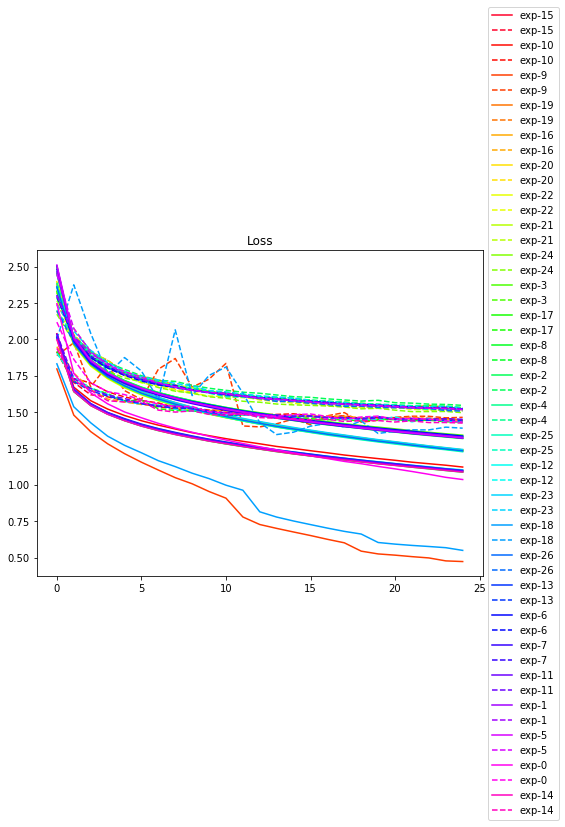

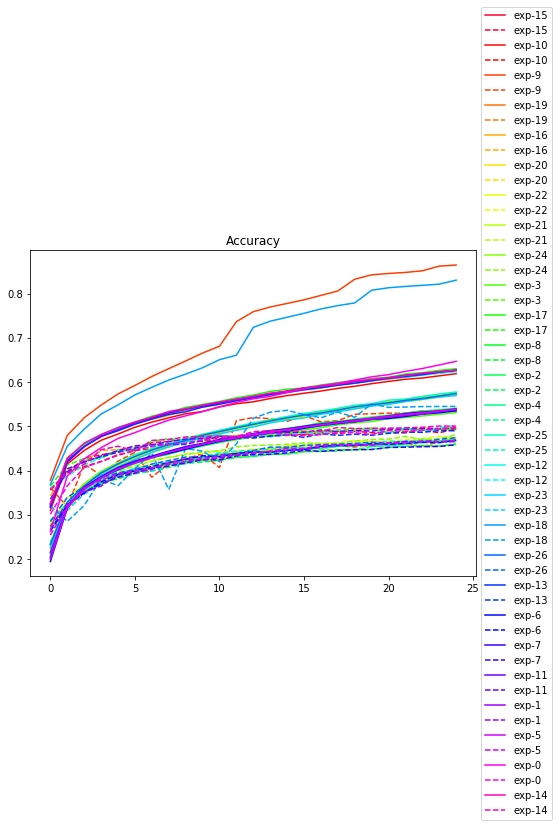

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()